# Apprenticeship Learning via IRL - Deep Q Network

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
from tqdm import tqdm

import gym
from dqn import DQNTrainer

## Cartpole-v0

Observations

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -4.8 | 4.8
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -0.418 rad (-24&deg;) | ~ 0.418 rad (24&deg;)
3 | Pole Velocity At Tip | -Inf | Inf

Actions:
Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right


Environment : CartPole-v0

Observation Space: Box(4,)

Action Space:  Discrete(2)

Initial State:  [ 0.00786003 -0.00498482  0.00024632 -0.04025897]

A step in the env: (array([ 0.00776034,  0.1901336 , -0.00055886, -0.33286417]), 1.0, False, {})


Rendered Environment: 


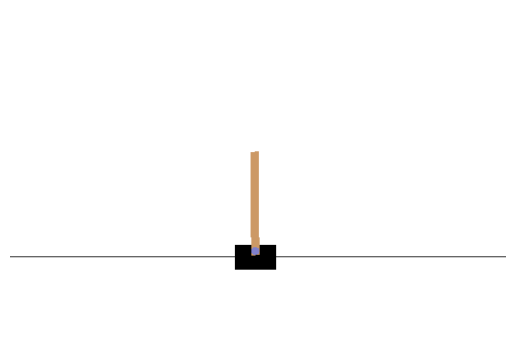

In [2]:
env = gym.make('CartPole-v0')
print('\nEnvironment : CartPole-v0')
print('\nObservation Space:', env.observation_space)
print('\nAction Space: ', env.action_space)
print('\nInitial State: ',env.reset())
print('\nA step in the env:', env.step(1))
print('\n\nRendered Environment: ')
env.reset()
plt.axis('off')
plt.imshow(env.render(mode='rgb_array'))
env.close()
plt.show()

# Training - Obtain Expert Policy

1. **Initialization:**
   - Use two neural networks: `policy_net` (online) and `target_net`.
   - Utilize a replay memory (`ReplayMemory`) to store experiences.

2. **Experience Replay:**
   - Store transitions (state, action, next state, reward) in the replay memory during interactions.

3. **Sample Batch:**
   - Periodically, sample a random batch of experiences from the replay memory.

4. **Double Q-Learning Update:**
   - Use `policy_net` to select actions for the next states in the sampled batch.
   - Use `target_net` to evaluate Q-values for the selected actions, addressing overestimation.

5. **Compute Loss:**
   - Calculate the loss using Huber loss between predicted Q-values and expected Q-values.
   - Expected Q-values are computed using `target_net` for the next states and considering discounted future rewards.

6. **Optimization:**
   - Minimize the computed loss using an optimizer, updating `policy_net` parameters via backpropagation.
   - Optionally apply gradient clipping for stability.

7. **Update Target Network:**
   - Periodically update `target_net` by copying weights from `policy_net`.

8. **Repeat:**
   - Repeat steps 2-7 over multiple episodes and iterations.

- The Double DQN approach mitigates overestimation bias in traditional Q-learning, improving stability and performance in deep reinforcement learning agents. The policy is represented by the Q-value function learned by the neural network.

In [3]:
dqn_trainer = DQNTrainer(env, agent='Expert', num_episodes=100, save_path='../Results/DQN/Expert_Training')

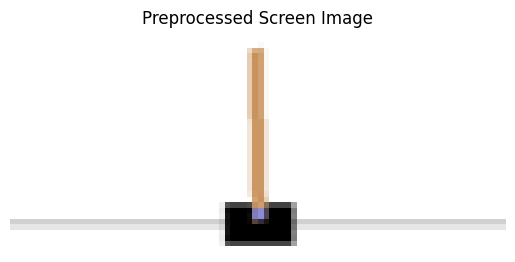

In [4]:
# the screen image from the environment is pre-processed before input to the neural network

dqn_trainer.show_screen_image()


Training Complete.


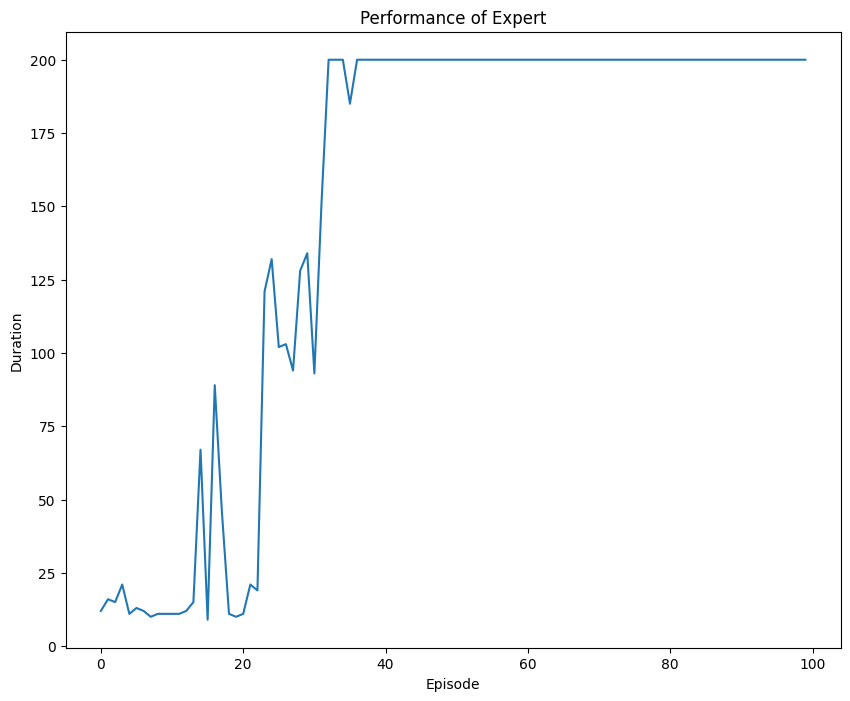

In [5]:
dqn_trainer.dqn_train(plot_save_path='../Results/DQN/Expert Performance.png', dynamic_plot=True)

In [6]:
dqn_trainer.save_trained_model()

Saved  ./data/Expert.pt


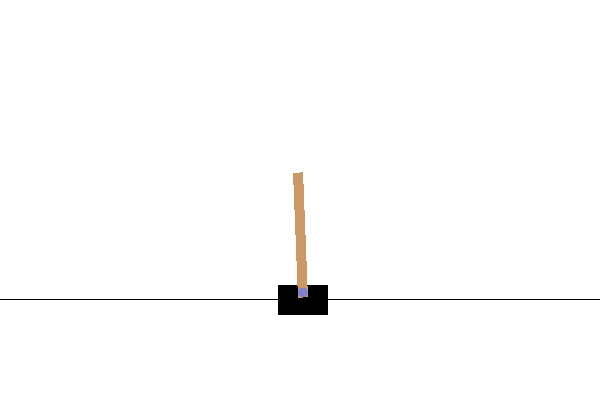

Expert Reward:  200.0


In [7]:
# visualize policy

expert_reward = dqn_trainer.test_model(dqn_trainer.best_model, render_save_path='../Results/DQN/Expert Policy')
print('Expert Reward: ',expert_reward)

# IRL Algorithm

* We define some functions for the Apprenticeship Inverse Reinforcement Learning (IRL) algorithm based on the paper by  P. Abbeel and A. Y. Ng titled "Apprenticeship Learning via Inverse Reinforcement Learning."

* To train new agents, instead of utilizing the (predefined) returned reward from the training environment, it incorporates the reward function of the expert derived from the IRL algorithm. This reward function involves a weight term (w) and observation space (Φ(s)) obtained through the IRL algorithm.

In [2]:
def compute_average_feature(dqn, m=2000):
        """
        Calculate average feature vector (feature expectation) and average reward over m episodes.
        """
        with torch.inference_mode():
            feature_sum, reward_sum = None, None

            for i in tqdm(range(m), desc='Calculating Average Feature Vector and Reward'):
                reward, states = dqn.test_model(dqn.best_model, save_states=True)

                # mean feature vector across the episode
                episode_mean = torch.stack(states).mean(0)

                if feature_sum is None:
                    feature_sum, reward_sum = episode_mean, reward
                else:
                    feature_sum += episode_mean
                    reward_sum += reward

            # µ̂E = (1/m) ∑_m ∑_t (γ^t φ(ŝ(i)_t))  where γ ≈ 1
            feature_sum /= m
            reward_sum /= m

            print('\nFeature Expectation: ',feature_sum)
            print('Average Reward: ',reward_sum)

        dqn.average_feature = feature_sum

        return feature_sum, reward_sum

In [3]:
expert = DQNTrainer(env, agent='Expert', load_path='./data/Expert.pt')

expert_feature_expectation, expert_mean_reward = compute_average_feature(dqn=expert, m=2000)   # µ_E

Loaded Model.


Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:30<00:00, 6


Feature Expectation:  tensor([0.5036, 0.5030, 0.5030, 0.5022, 0.2544, 0.2541, 0.2533, 0.4830])
Average Reward:  200.0


## IRL algorithm using Projection method

1. **Initialization:**
   - Randomly pick an initial policy, denoted as π(0).
   - Compute the feature expectation, µ(0), using Monte Carlo or other approximation methods.
   - Set iteration counter i = 1.

2. **Margin Computation:**
   - Compute the margin, t(i), as the maximum margin between the current feature expectation and those of previous policies.
   - Formulate the margin computation as a quadratic program to find the optimal weight vector w(i).

3. **Termination Check:**
   - If the margin t(i) is less than or equal to a predefined threshold ε, terminate the algorithm.

4. **IRL Training:**
   - Use a Reinforcement Learning (RL) algorithm to compute the optimal policy π(i) for the Markov Decision Process (MDP) with rewards defined by the weight vector w(i).

5. **Update Feature Expectation:**
   - Compute or estimate the feature expectation, µ(i), based on the new policy π(i).

6. **Iteration Update:**
   - Increment the iteration counter i.

7. **Repeat:**
   - Return to step 2 and iterate through the process until the termination condition is met.

Upon termination, the algorithm returns a set of policies {π(i) : i = 0 . . . n}, representing a sequence of policies that approximate the expert's behavior.

In [4]:
def projection_method_algorithm(env, epsilon=0.0001, iterations=11):
    
    feature_expectation = []
    feature_expectation_bar = []
    weights = []
    margins = []
    rewards = []

    for i in range(iterations):
        print(f"\n-------------------- Iteration: {i} --------------------\n")
        apprentice = DQNTrainer(env, agent=f'Apprentice {i}', num_episodes=100)

        # Step 1: Initialization
        if i == 0:
            sample_feature = apprentice.construct_feature_vector(env.reset())
            w_0 = torch.randn(sample_feature.size(0), 1).div_(torch.randn(1).norm())
            weights.append(w_0)
            apprentice.dqn_train(reward_weight=w_0, plot_save_path=f'../Results/DQN/Apprentice_{i} Performance.png')
            apprentice_feature_expectation, apprentice_reward = compute_average_feature(dqn=apprentice, m=2000)
            
            rewards.append(apprentice_reward)
            margins.append(1)
            feature_expectation.append(apprentice_feature_expectation)
            
            print("Expert Feature Expectation:", expert_feature_expectation)
            
        else:
            # Step 2: IRL
            # First iteration of step 2 of algorithm
            if i == 1:
                feature_expectation_bar.append(feature_expectation[i - 1])       # µ¯^(0) = µ^(0)
                weights.append((expert_feature_expectation - feature_expectation[i - 1]).view(-1, 1))   # w^(1) = µ_E - µ^(0)
                margins.append((expert_feature_expectation - feature_expectation_bar[i - 1]).norm().item())
                print("Weight:", weights[i])
                print("Margin:", margins[i])

            # Iterations 2 and onward of step 2 of algorithm
            else:
                A = feature_expectation_bar[i - 2]              # µ¯(i−2)
                B = feature_expectation[i - 1] - A              # (µ(i−1) − µ¯(i−2))
                C = expert_feature_expectation - A              # µ_E − µ¯(i−2)

                feature_expectation_bar.append(A + ((B.view(-1, 1).t() @ C.view(-1, 1)) / \
                                                    (B.view(-1, 1).t() @ B.view(-1, 1))) * B)  # projection method step

                # w(i) = µ_E − μ¯(i−1)
                weight = (expert_feature_expectation - feature_expectation_bar[i - 1]).view(-1, 1)

                # t(i) = ∥µ_E − µ¯(i−1)∥_2
                margin = (expert_feature_expectation - feature_expectation_bar[i - 1]).norm().item()
                
                weights.append(weight)
                margins.append(margin)
                
                print("Margin:", margins[i])
                print("Weight:", weights[i])

            # Step 3: Termination condition
            if margins[i] <= epsilon:
                break                   # terminate with margin ≤ ∈ (or iteration)

            # Step 4: IRL training
            apprentice.dqn_train(reward_weight=weights[-1], 
                                 plot_save_path=f'../Results/DQN/Apprentice_{i} Performance.png')
            apprentice.save_trained_model()

            # Step 5: Update feature expectation
            apprentice_feature_expectation, apprentice_reward = compute_average_feature(dqn=apprentice, m=2000)
            rewards.append(apprentice_reward)
            feature_expectation.append(apprentice_feature_expectation)

        print("")
        
    return rewards, margins


-------------------- Iteration: 0 --------------------



Training..: 100%|█████████████████████████████| 100/100 [00:04<00:00, 24.76it/s]


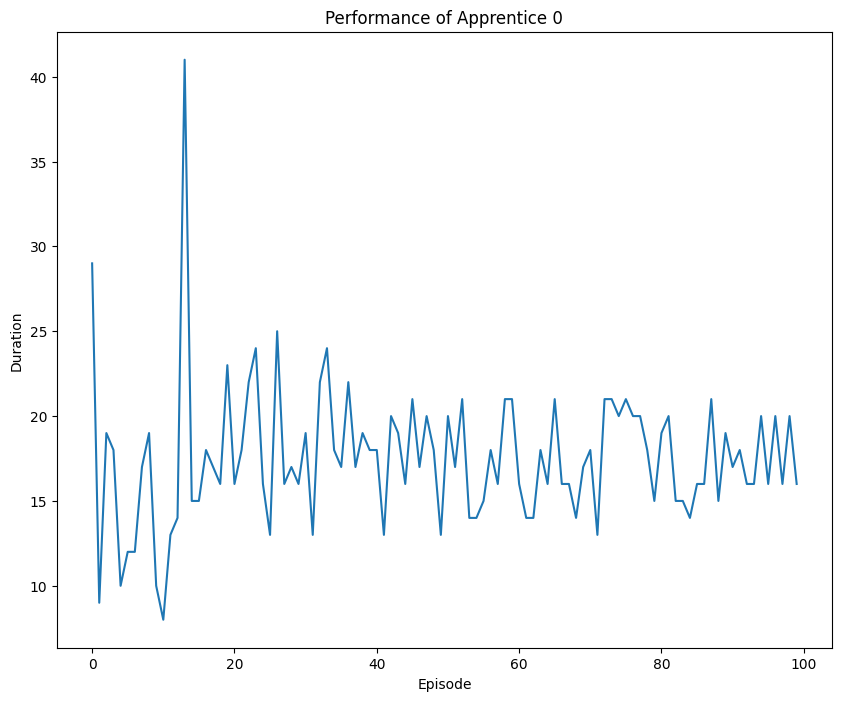

Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:02<00:00, 6



Feature Expectation:  tensor([ 0.5125,  0.5635,  0.2612, -0.9398,  0.2628,  0.3188,  0.0974,  1.1816])
Average Reward:  17.9555
Expert Feature Expectation: tensor([0.5036, 0.5030, 0.5030, 0.5022, 0.2544, 0.2541, 0.2533, 0.4830])


-------------------- Iteration: 1 --------------------

Weight: tensor([[-0.0090],
        [-0.0604],
        [ 0.2418],
        [ 1.4421],
        [-0.0084],
        [-0.0647],
        [ 0.1559],
        [-0.6986]])
Margin: 1.6304618120193481


Training..: 100%|█████████████████████████████| 100/100 [00:11<00:00,  8.98it/s]


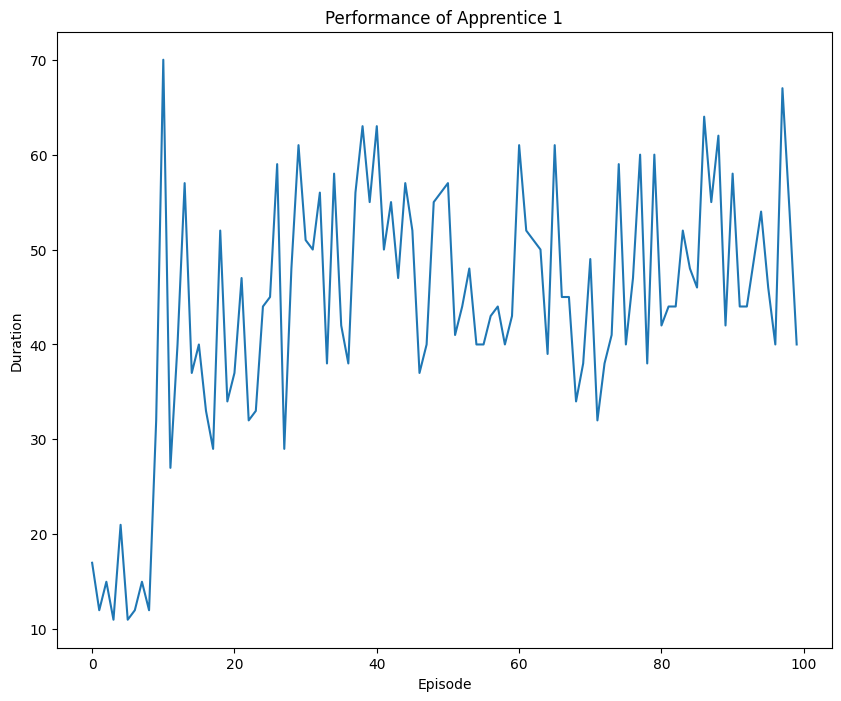

Saved  ./data/Apprentice 1.pt


Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:08<00:00, 2



Feature Expectation:  tensor([0.4998, 0.5313, 0.7306, 1.0038, 0.2500, 0.2858, 0.5573, 1.1808])
Average Reward:  52.0965


-------------------- Iteration: 2 --------------------

Margin: 0.7291813492774963
Weight: tensor([[ 1.0902e-04],
        [-3.7535e-02],
        [-9.1765e-02],
        [ 6.0973e-02],
        [ 7.4315e-04],
        [-4.1240e-02],
        [-1.7087e-01],
        [-6.9804e-01]])


Training..: 100%|█████████████████████████████| 100/100 [00:12<00:00,  7.98it/s]


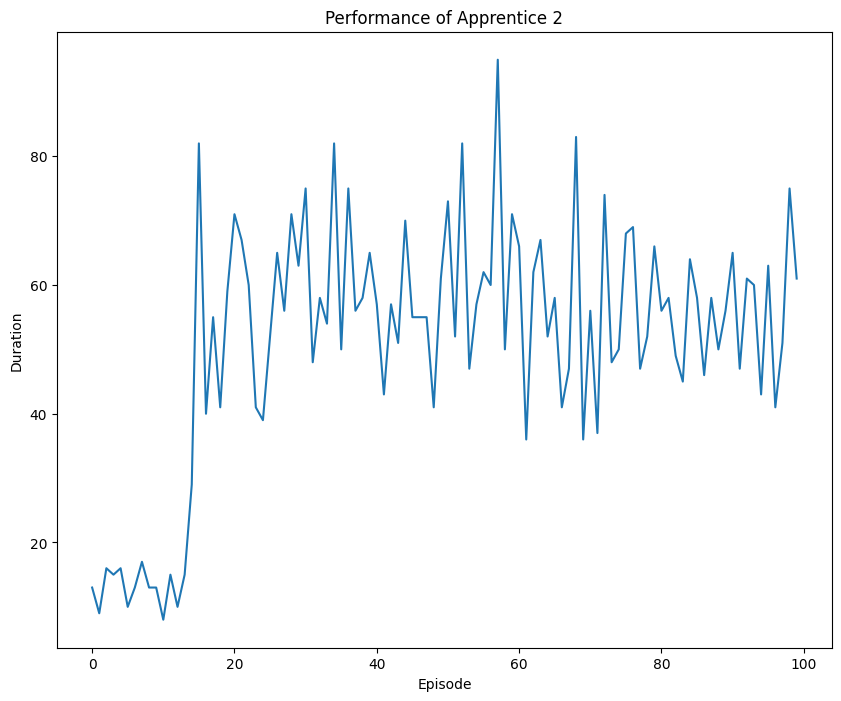

Saved  ./data/Apprentice 2.pt


Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:10<00:00, 1



Feature Expectation:  tensor([0.4931, 0.4455, 0.2607, 0.0961, 0.2437, 0.2047, 0.0921, 0.1685])
Average Reward:  64.164


-------------------- Iteration: 3 --------------------

Margin: 0.30249711871147156
Weight: tensor([[ 0.0059],
        [ 0.0161],
        [ 0.0966],
        [ 0.2556],
        [ 0.0064],
        [ 0.0099],
        [ 0.0165],
        [-0.1269]])


Training..: 100%|█████████████████████████████| 100/100 [00:11<00:00,  8.39it/s]


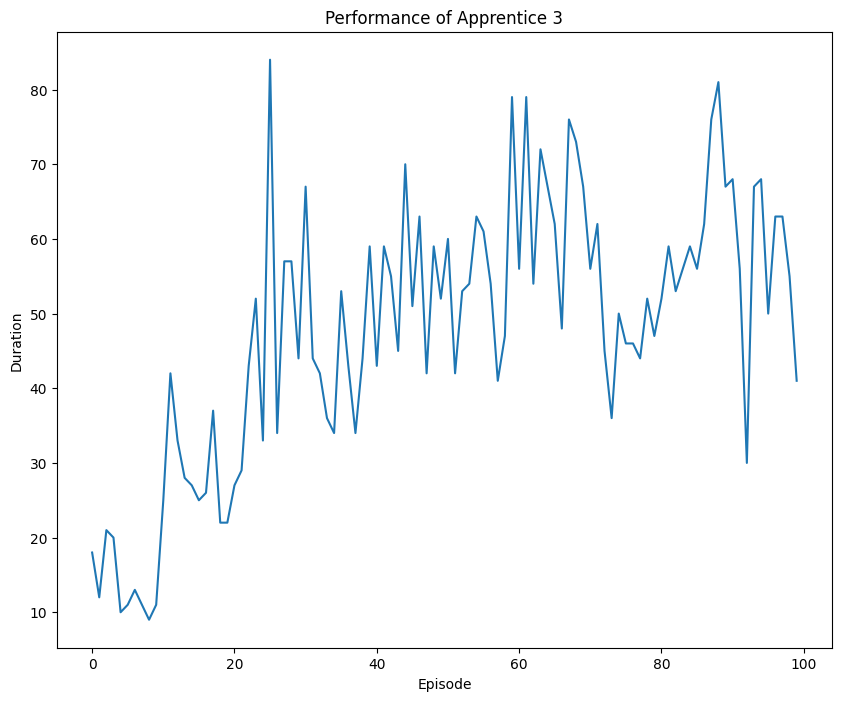

Saved  ./data/Apprentice 3.pt


Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:17<00:00, 1



Feature Expectation:  tensor([0.5521, 0.6145, 0.7081, 0.7045, 0.3119, 0.3951, 0.5278, 0.6813])
Average Reward:  109.8155


-------------------- Iteration: 4 --------------------

Margin: 0.2062193900346756
Weight: tensor([[-0.0123],
        [-0.0266],
        [-0.0044],
        [ 0.1023],
        [-0.0150],
        [-0.0407],
        [-0.0810],
        [-0.1508]])


Training..: 100%|█████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


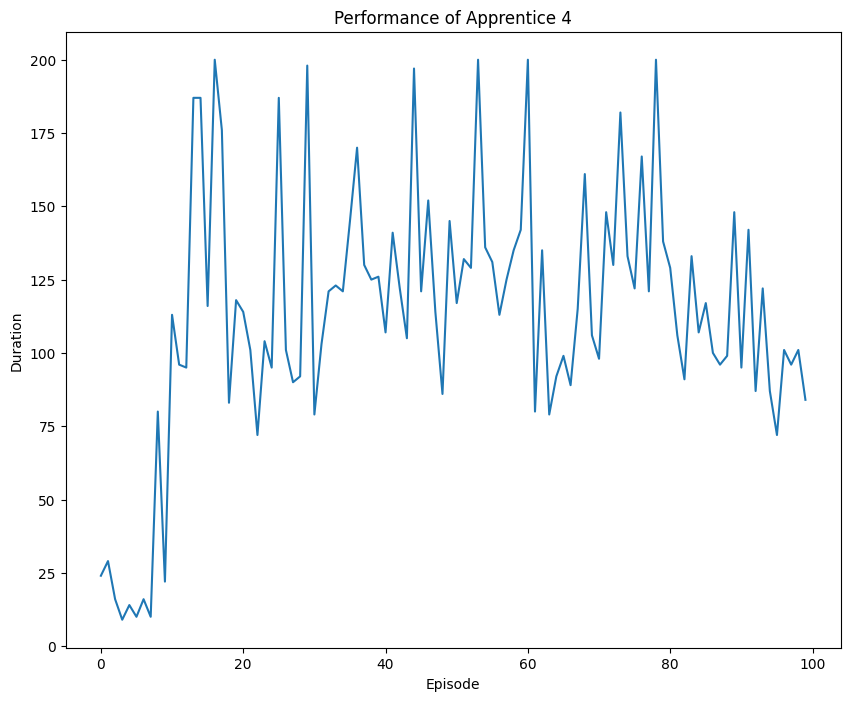

Saved  ./data/Apprentice 4.pt


Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:30<00:00, 6



Feature Expectation:  tensor([0.4282, 0.4206, 0.4166, 0.4212, 0.1996, 0.1868, 0.1820, 0.3694])
Average Reward:  188.4355


-------------------- Iteration: 5 --------------------

Margin: 0.11236493289470673
Weight: tensor([[ 0.0285],
        [ 0.0241],
        [ 0.0378],
        [ 0.0924],
        [ 0.0175],
        [ 0.0096],
        [-0.0101],
        [-0.0277]])


Training..: 100%|█████████████████████████████| 100/100 [00:08<00:00, 11.31it/s]


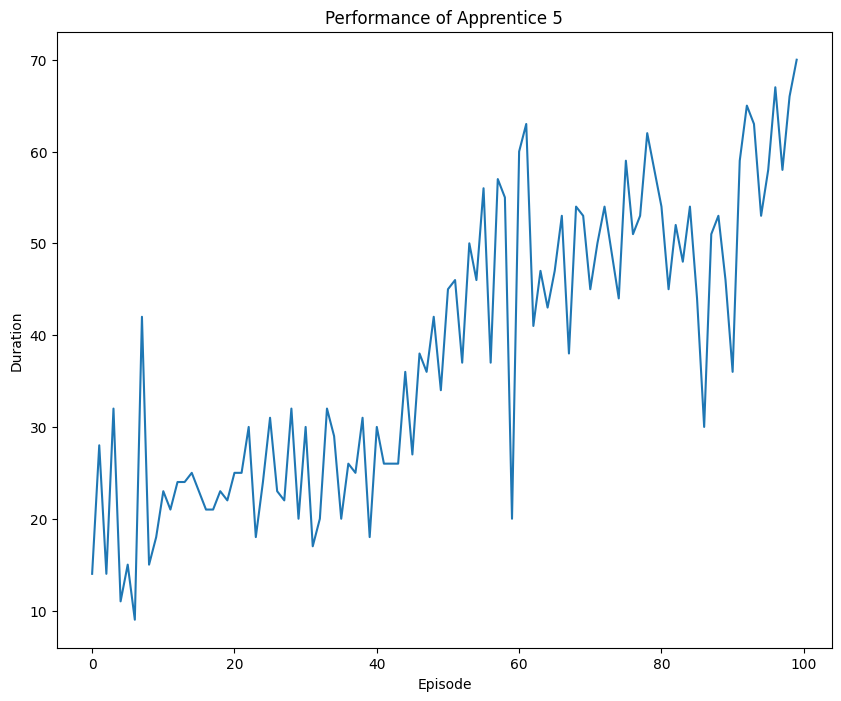

Saved  ./data/Apprentice 5.pt


Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:09<00:00, 2



Feature Expectation:  tensor([0.5281, 0.6265, 0.8583, 0.9115, 0.2813, 0.4122, 0.7579, 1.1548])
Average Reward:  61.3055


-------------------- Iteration: 6 --------------------

Margin: 0.10368857532739639
Weight: tensor([[ 0.0264],
        [ 0.0181],
        [ 0.0218],
        [ 0.0718],
        [ 0.0157],
        [ 0.0027],
        [-0.0303],
        [-0.0541]])


Training..: 100%|█████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]


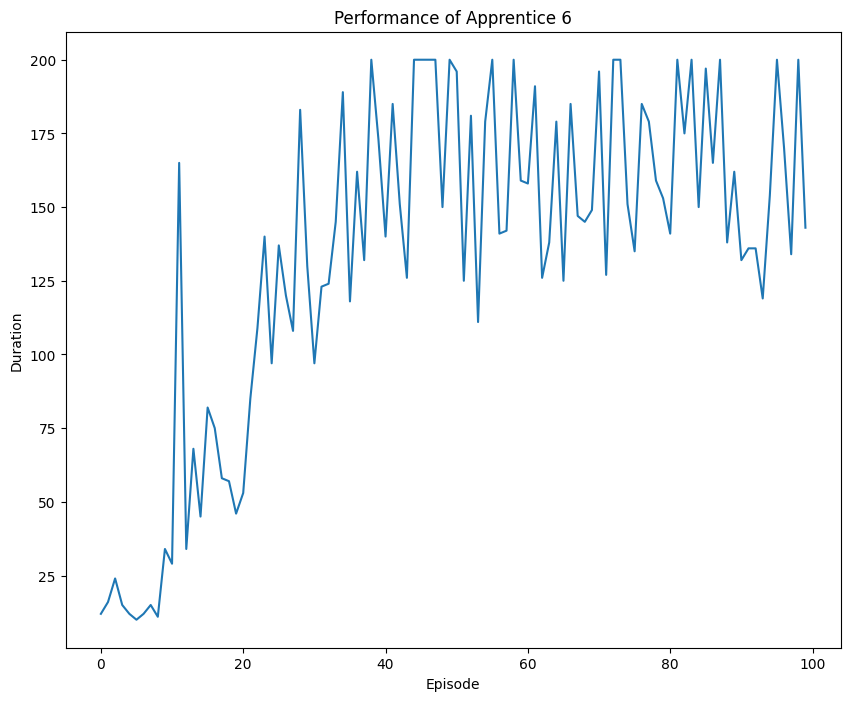

Saved  ./data/Apprentice 6.pt


Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:25<00:00, 7



Feature Expectation:  tensor([0.6176, 0.6614, 0.6853, 0.6150, 0.4041, 0.4608, 0.4803, 0.5423])
Average Reward:  152.75


-------------------- Iteration: 7 --------------------

Margin: 0.09377215802669525
Weight: tensor([[ 0.0136],
        [ 0.0020],
        [ 0.0032],
        [ 0.0550],
        [ 0.0006],
        [-0.0163],
        [-0.0482],
        [-0.0545]])


Training..: 100%|█████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]


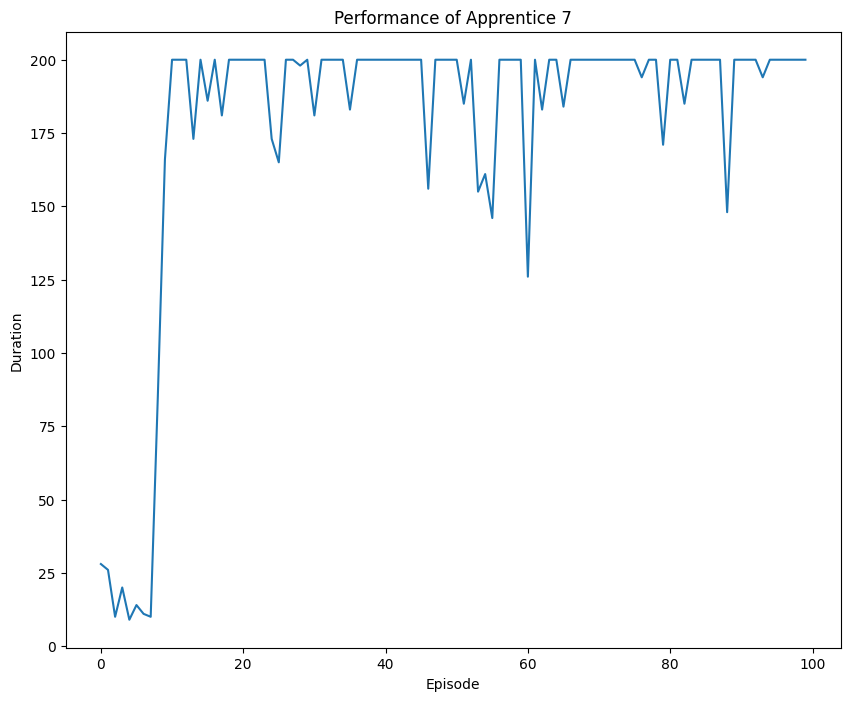

Saved  ./data/Apprentice 7.pt


Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:31<00:00, 6



Feature Expectation:  tensor([0.4900, 0.4975, 0.5060, 0.5029, 0.2597, 0.2582, 0.2607, 0.4195])
Average Reward:  195.4875


-------------------- Iteration: 8 --------------------

Margin: 0.039776694029569626
Weight: tensor([[ 0.0136],
        [ 0.0042],
        [-0.0006],
        [ 0.0207],
        [-0.0030],
        [-0.0088],
        [-0.0230],
        [ 0.0183]])


Training..: 100%|█████████████████████████████| 100/100 [00:02<00:00, 44.34it/s]


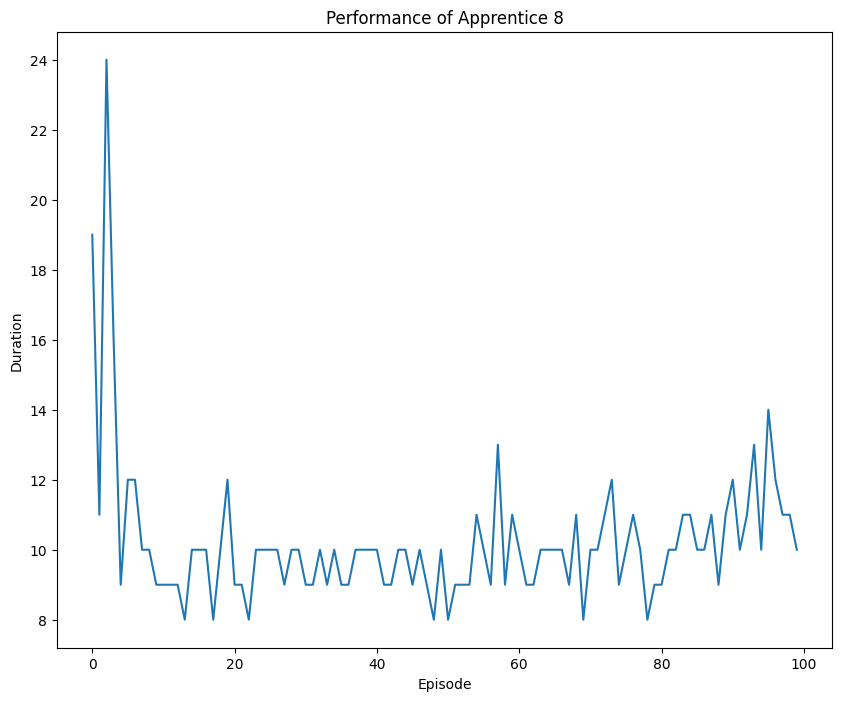

Saved  ./data/Apprentice 8.pt


Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:02<00:00, 9



Feature Expectation:  tensor([0.4875, 0.3855, 0.7155, 2.6479, 0.2378, 0.1510, 0.5457, 7.8275])
Average Reward:  12.5135


-------------------- Iteration: 9 --------------------

Margin: 0.03271950036287308
Weight: tensor([[ 0.0136],
        [ 0.0045],
        [-0.0013],
        [ 0.0143],
        [-0.0030],
        [-0.0084],
        [-0.0238],
        [-0.0034]])


Training..: 100%|█████████████████████████████| 100/100 [00:06<00:00, 15.79it/s]


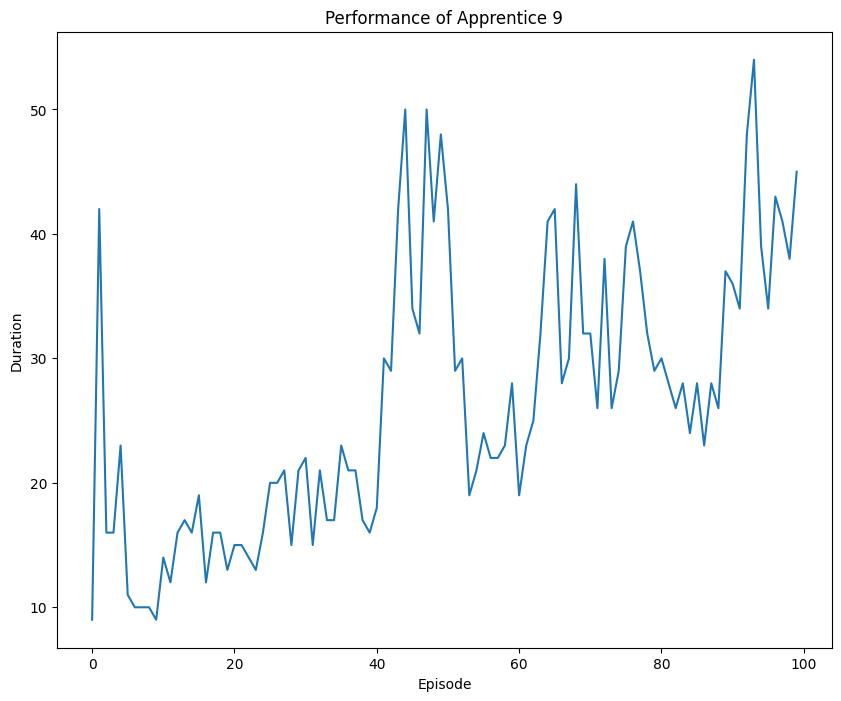

Saved  ./data/Apprentice 9.pt


Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:08<00:00, 2



Feature Expectation:  tensor([0.4950, 0.5003, 0.6841, 1.1316, 0.2451, 0.2513, 0.4883, 1.7226])
Average Reward:  48.2285


-------------------- Iteration: 10 --------------------

Margin: 0.03271948918700218
Weight: tensor([[ 0.0136],
        [ 0.0045],
        [-0.0013],
        [ 0.0143],
        [-0.0030],
        [-0.0084],
        [-0.0238],
        [-0.0034]])


Training..: 100%|█████████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


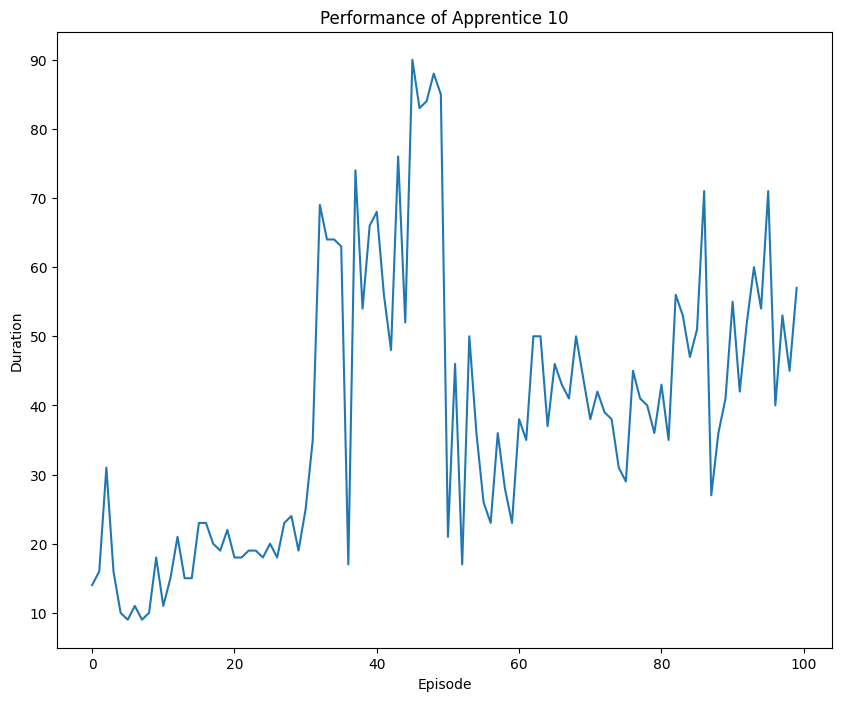

Saved  ./data/Apprentice 10.pt


Calculating Average Feature Vector and Reward: 100%|█| 2000/2000 [00:15<00:00, 1


Feature Expectation:  tensor([0.5952, 0.6717, 0.7799, 0.7789, 0.3728, 0.4782, 0.6208, 0.8441])
Average Reward:  98.214



In [5]:
rewards, margins = projection_method_algorithm(env, iterations=11)

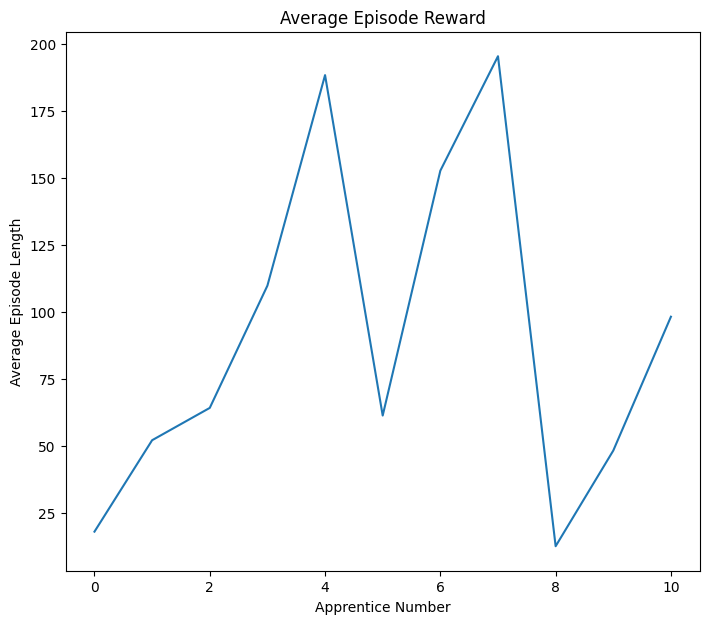

In [6]:
# Performance comparison of apprentices

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Average Episode Reward')
plt.xlabel('Apprentice Number')
plt.ylabel('Average Episode Length')
plt.savefig("../Results/DQN/Apprentice Rewards.png")
plt.show()

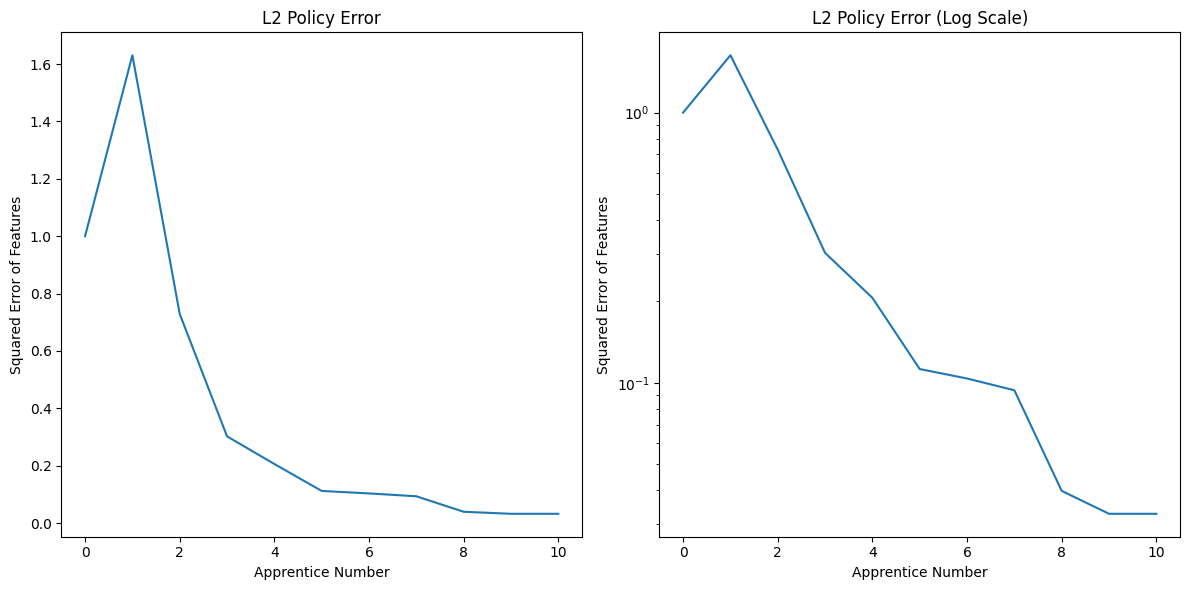

In [7]:
# L2 Policy Error
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# plot without log scale
axes[0].plot(margins, label="L2 Policy Error")
axes[0].set_title("L2 Policy Error")
axes[0].set_xlabel("Apprentice Number")
axes[0].set_ylabel("Squared Error of Features")

# plot with log scale
axes[1].plot(margins, label="L2 Policy Error")
axes[1].set_title("L2 Policy Error (Log Scale)")
axes[1].set_xlabel("Apprentice Number")
axes[1].set_ylabel("Squared Error of Features")
axes[1].set_yscale("log")

plt.tight_layout()
plt.savefig("../Results/DQN/Apprentice Policy Error.png")
plt.show()

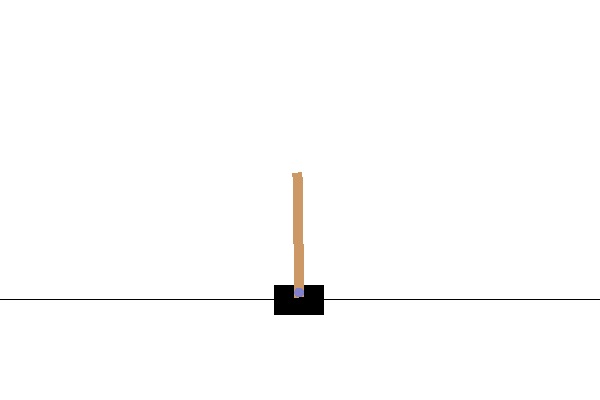

Apprentice 1 -  56.0


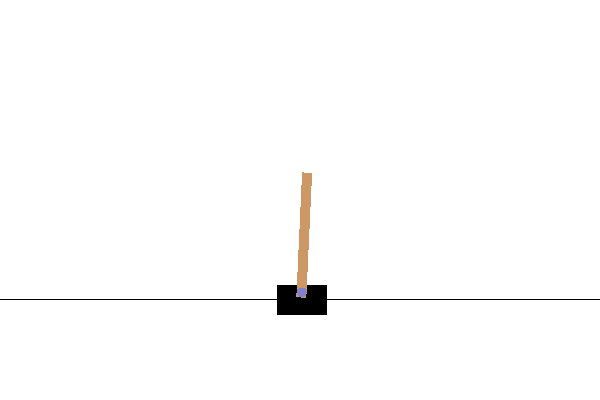

Apprentice 2 -  88.0


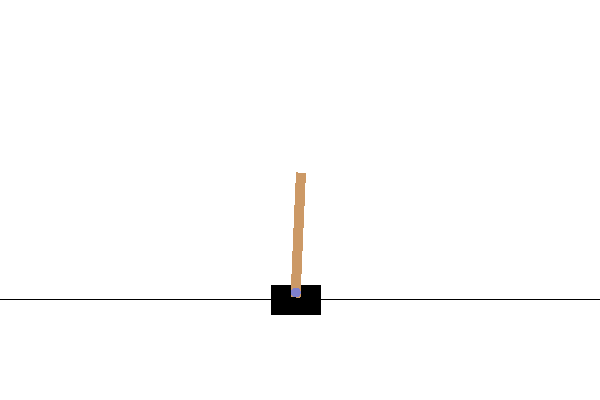

Apprentice 3 -  87.0


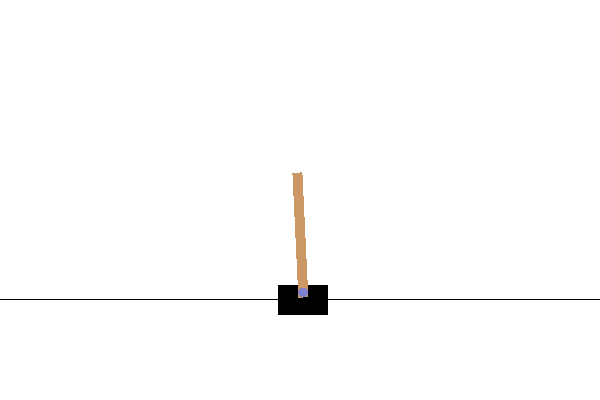

Apprentice 4 -  160.0


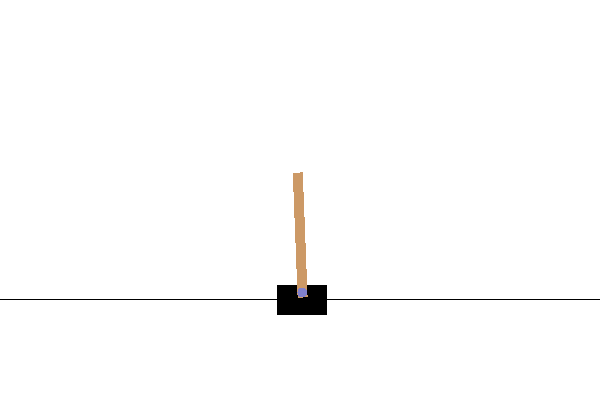

Apprentice 5 -  66.0


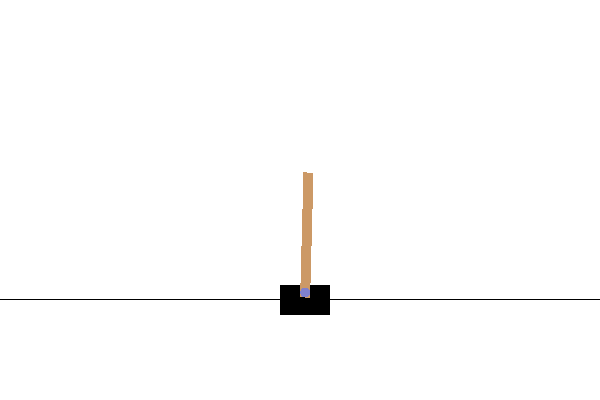

Apprentice 6 -  130.0


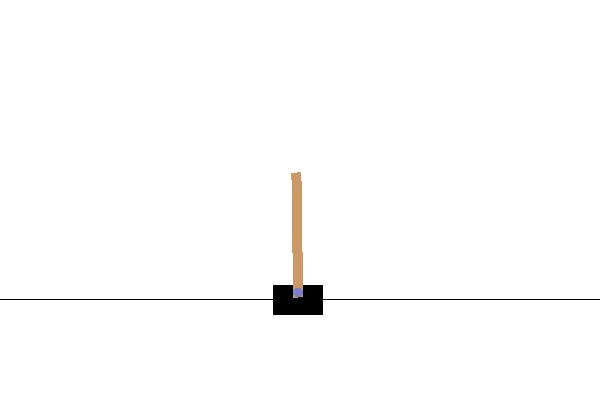

Apprentice 7 -  200.0


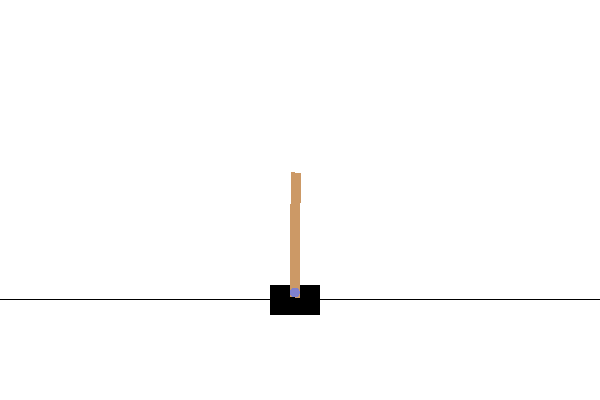

Apprentice 8 -  12.0


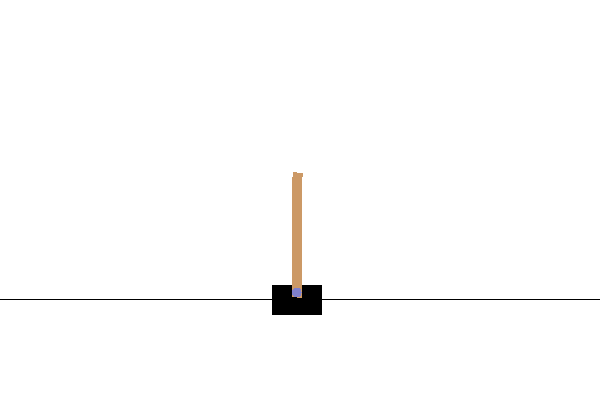

Apprentice 9 -  41.0


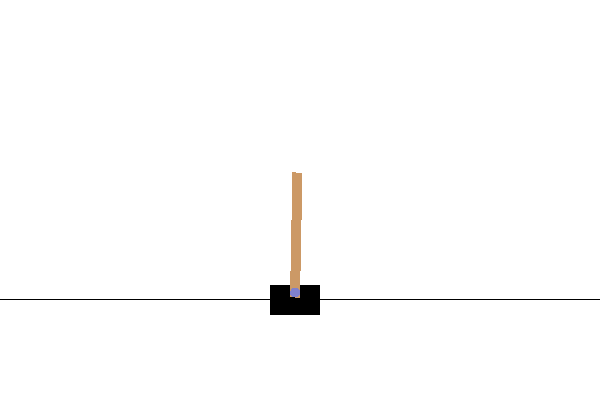

Apprentice 10 -  112.0


In [3]:
for i in range(1, 11):
    apprentice = DQNTrainer(env, agent=f'Apprentice {i}', load_path=f'./data/Apprentice {i}.pt')
    apprentice_reward = apprentice.test_model(model=apprentice.best_model, 
                                              render_save_path=f'../Results/DQN/Apprentice {i} Policy')
    print(f'{apprentice.agent} - ', apprentice_reward)